## Project: CutMix, Mixup 비교실험

## import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### load dataset

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## normalization and augmentation

### Onehot

In [3]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []
    for i in range(batch_size):
        onehot_imgs.append(image[i])
        onehot_labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))

    return onehot_imgs, onehot_labels

### cutmix

In [4]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

# xa, ya, xb, yb = get_clip_box(image_a, image_b)
# print(xa, ya, xb, yb)

In [5]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
# plt.imshow(mixed_img.numpy())

In [6]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

# mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
# mixed_label

In [7]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

# mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
# plt.imshow(mixed_img.numpy())
# print(mixed_label)

In [9]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## model training

In [11]:
BATCH_SIZE = 16
EPOCHS = 20

In [12]:
tf.random.set_seed(2020)
num_classes = ds_info.features["label"].num_classes

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=BATCH_SIZE)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, batch_size=BATCH_SIZE)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True, batch_size=BATCH_SIZE)

In [14]:
import pickle

In [41]:
model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = model.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 121s 161ms/step - loss: 2.2075 - accuracy: 0.4472 - val_loss: 3.2626 - val_accuracy: 0.2347
Epoch 2/20
750/750 [==============================] - 122s 162ms/step - loss: 0.7867 - accuracy: 0.7831 - val_loss: 1.1364 - val_accuracy: 0.6720
Epoch 3/20
750/750 [==============================] - 124s 166ms/step - loss: 0.3096 - accuracy: 0.9268 - val_loss: 0.9508 - val_accuracy: 0.7241
Epoch 4/20
750/750 [==============================] - 124s 166ms/step - loss: 0.0934 - accuracy: 0.9874 - val_loss: 0.9259 - val_accuracy: 0.7361
Epoch 5/20
750/750 [==============================] - 125s 166ms/step - loss: 0.0321 - accuracy: 0.9984 - val_loss: 0.8912 - val_accuracy: 0.7458
Epoch 6/20
750/750 [==============================] - 122s 162ms/step - loss: 0.0325 - accuracy: 0.9983 - val_loss: 0.9292 - val_accuracy: 0.7425
Epoch 7/20
750/750 [==============================] - 119s 158ms/step - loss: 0.0218 - accuracy: 0.9984 - val_loss: 0.9372 -

In [43]:
model.save_weights('resnet50_no_aug.h5')

In [47]:
path = 'history_resnet50_no_aug.pkl'
pickle.dump(history_resnet50_no_aug.history, open(path, 'wb'))

In [15]:
model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = model.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 121s 161ms/step - loss: 2.2467 - accuracy: 0.4367 - val_loss: 3.1047 - val_accuracy: 0.2472
Epoch 2/20
750/750 [==============================] - 120s 160ms/step - loss: 0.9521 - accuracy: 0.7218 - val_loss: 1.4741 - val_accuracy: 0.5891
Epoch 3/20
750/750 [==============================] - 124s 165ms/step - loss: 0.5447 - accuracy: 0.8461 - val_loss: 1.4333 - val_accuracy: 0.5946
Epoch 4/20
750/750 [==============================] - 127s 169ms/step - loss: 0.3258 - accuracy: 0.9137 - val_loss: 1.0817 - val_accuracy: 0.6855
Epoch 5/20
750/750 [==============================] - 125s 166ms/step - loss: 0.1795 - accuracy: 0.9612 - val_loss: 1.0463 - val_accuracy: 0.7045
Epoch 6/20
750/750 [==============================] - 113s 150ms/step - loss: 0.1054 - accuracy: 0.9806 - val_loss: 0.9797 - val_accuracy: 0.7274
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0674 - accuracy: 0.9901 - val_loss: 0.9828 -

In [16]:
model.save_weights('resnet50_aug.h5')

In [17]:
path = 'resnet50_aug.pkl'
pickle.dump(history_resnet50_aug.history, open(path, 'wb'))

In [18]:
model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = model.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 122s 163ms/step - loss: 2.2489 - accuracy: 0.4328 - val_loss: 3.4235 - val_accuracy: 0.2006
Epoch 2/20
750/750 [==============================] - 121s 161ms/step - loss: 0.9395 - accuracy: 0.7262 - val_loss: 1.2406 - val_accuracy: 0.6393
Epoch 3/20
750/750 [==============================] - 122s 163ms/step - loss: 0.5482 - accuracy: 0.8470 - val_loss: 1.1585 - val_accuracy: 0.6610
Epoch 4/20
750/750 [==============================] - 123s 164ms/step - loss: 0.2960 - accuracy: 0.9244 - val_loss: 1.0035 - val_accuracy: 0.7062
Epoch 5/20
750/750 [==============================] - 126s 167ms/step - loss: 0.1784 - accuracy: 0.9622 - val_loss: 1.0840 - val_accuracy: 0.7013
Epoch 6/20
750/750 [==============================] - 123s 165ms/step - loss: 0.1017 - accuracy: 0.9817 - val_loss: 0.9940 - val_accuracy: 0.7246
Epoch 7/20
750/750 [==============================] - 121s 161ms/step - loss: 0.0769 - accuracy: 0.9862 - val_loss: 1.0371 -

In [19]:
model.save_weights('resnet50_aug_cutmix.h5')

In [20]:
path = 'resnet50_aug_cutmix.pkl'
pickle.dump(history_resnet50_aug_cutmix.history, open(path, 'wb'))

In [21]:
model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = model.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 122s 163ms/step - loss: 2.2691 - accuracy: 0.4303 - val_loss: 3.0326 - val_accuracy: 0.2703
Epoch 2/20
750/750 [==============================] - 123s 164ms/step - loss: 0.9702 - accuracy: 0.7213 - val_loss: 1.1998 - val_accuracy: 0.6498
Epoch 3/20
750/750 [==============================] - 124s 165ms/step - loss: 0.5469 - accuracy: 0.8447 - val_loss: 1.0552 - val_accuracy: 0.6891
Epoch 4/20
750/750 [==============================] - 120s 160ms/step - loss: 0.3119 - accuracy: 0.9179 - val_loss: 1.1232 - val_accuracy: 0.6797
Epoch 5/20
750/750 [==============================] - 120s 160ms/step - loss: 0.1845 - accuracy: 0.9592 - val_loss: 1.0337 - val_accuracy: 0.7084
Epoch 6/20
750/750 [==============================] - 121s 162ms/step - loss: 0.1190 - accuracy: 0.9777 - val_loss: 0.9982 - val_accuracy: 0.7172
Epoch 7/20
750/750 [==============================] - 119s 159ms/step - loss: 0.0822 - accuracy: 0.9851 - val_loss: 1.0219 -

In [22]:
model.save_weights('resnet50_aug_mixup.h5')

In [23]:
path = 'resnet50_aug_mixup.pkl'
pickle.dump(history_resnet50_aug_mixup.history, open(path, 'wb'))

## visualization

In [25]:
history_resnet50_no_aug = pickle.load(open('resnet50_no_aug.pkl', 'rb'))
history_resnet50_aug = pickle.load(open('resnet50_aug.pkl', 'rb'))
history_resnet50_aug_cutmix = pickle.load(open('resnet50_aug_cutmix.pkl', 'rb'))
history_resnet50_aug_mixup = pickle.load(open('resnet50_aug_mixup.pkl', 'rb'))

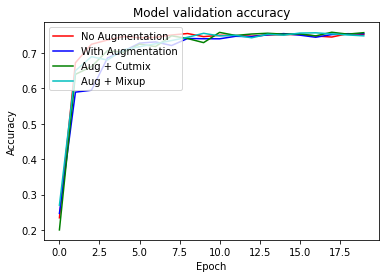

In [26]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper left')
plt.show()

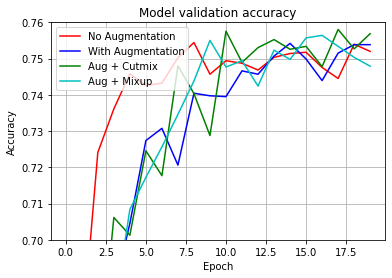

In [29]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.70, 0.76)
plt.show()

## 결론

1. CutMix, Mixup을 적용한 데이터셋으로 모델을 훈련했을 때, 유의미한 학습이 수행됨
    - 하지만, 수렴까지는 추가적인 학습이 필요할 것으로 생각됨
2. 데이터 증강과 증강하지 않았을 때의 차이는 없었음
    - 이 현상은 아직 모델이 최적화되지 않아서 발생한 문제로 생각됨
    - 왜냐면, 데이터 증강이 없는 경우 빠르게 수렴했지만
    - 데이터 증강을 한 경우엔 학습이 덜 된 듯한 양상을 보이기 때문
    - 즉, 추가로 학습을 진행하면 유의미한 차이가 있을지 확인이 가능할 것으로 생각됨
3. 4가지 방법(Aug, No Aug, Aug + CutMix, Aug + Mixup)으로 실험을 진행하고, 학습양상을 시각화 성공함
4. 추가 실험 필요사항
    - epochs를 20 -> 40~50으로 늘려, 유의미한 성능향상이 있는지 확인이 필요함